In [1]:
import os,sys; sys.path.insert(0,'/Users/ryan/github/lltk/lltk/corpus/epistolary')
import os,sys; sys.path.insert(0,'/Users/ryan/github/abslithist')
from epistolary import *
from abslithist import *

In [2]:
# !pip install -r /Users/ryan/github/abslithist/requirements.txt
# !pip install gensim

In [70]:
texts = get_pamela().letters.texts() + get_clarissa().letters.texts() + get_evelina().letters.texts()
len(texts)

[06:48:39] lltk.corpus.corpus.init():263: Initializing from metadata: [Epistolary](epistolary)
[06:48:39] lltk.corpus.corpus.init():263: Initializing from metadata: [SectionCorpusLetterChadwyck](letters)
[06:48:41] lltk.corpus.corpus.init():263: Initializing from metadata: [Epistolary](epistolary)
[06:48:41] lltk.corpus.corpus.init():263: Initializing from metadata: [SectionCorpusLetterChadwyck](letters)
[06:48:43] lltk.corpus.corpus.init():263: Initializing from metadata: [Epistolary](epistolary)
[06:48:43] lltk.corpus.corpus.init():263: Initializing from metadata: [SectionCorpusLetterChadwyck](letters)


968

In [71]:
def tokens_absconc(self, pos={'ADJ','VERB','NOUN','ADV'},tfield=f'Abs-Conc.Median.C18'):
    df=self.booknlp.tokens()
    if not 'pos' in set(df.columns): return pd.DataFrame()
    df=df[df.pos.isin(pos)]
    for k,v in self.meta.items(): df[k]=v
    df['id_text']=self.source.id

    norms=get_allnorms()
    normsok=norms[tfield].dropna()
    stopwords=get_stopwords()

    df['absconc']=df.lemma.apply(lambda x: normsok.loc[x.lower()] if x in set(normsok.index) and x not in stopwords else np.nan)
    df=df[~df['absconc'].isna()]
    df['_i']=list(range(len(df)))
    df['absconc_rolling_50_25'] = df.absconc.rolling(50,min_periods=25).mean()
    df['absconc_rolling_50'] = df.absconc.rolling(50,min_periods=1).mean()
    
    return df

In [72]:
tokens_absconc(random.choice(texts))

para_i  sent_i  sent_token_i         token         lemma  \
text_id token_i                                                             
L122a   13            2       2             0          Late          late   
        18            2       2             5           bed           bed   
        25            2       2            12          rest          rest   
        37            2       4             9         court         court   
        47            2       5             1          hope          hope   
...                 ...     ...           ...           ...           ...   
        546          11      26            12           set           set   
        553          11      26            19        advise        advise   
        555          11      26            21      contrary      contrary   
        560          11      27             3           add           add   
        568          12      27            11  affectionate  affectionate   

                 onset  offset   pos pos2  deprel  ...  id_parent place notes  \
text_id token_i                                    ...                          
L122a   13          69      73   ADV   RB  advmod  ...                    NaN   
        18          87      90  NOUN   NN    pobj  ...                    NaN   
        25         115     119  NOUN   NN    dobj  ...                    NaN   
        37         163     168  VERB  VBP   relcl  ...                    NaN   
        47         199     203  VERB  VBP    ROOT  ...                    NaN   
...                ...     ...   ...  ...     ...  ...        ...   ...   ...   
        546       2365    2368  VERB   VB     acl  ...                    NaN   
        553       2396    2402  VERB  VBP   advcl  ...                    NaN   
        555       2407    2415  NOUN   NN    dobj  ...                    NaN   
        560       2429    2432  VERB   VB    ROOT  ...                    NaN   
        568       2455    2467  NOUN   NN    amod  ...                    NaN   

                place_ner     id  \
text_id token_i                    
L122a   13                 L122a   
        18                 L122a   
        25                 L122a   
        37                 L122a   
        47                 L122a   
...                   ...    ...   
        546                L122a   
        553                L122a   
        555                L122a   
        560                L122a   
        568                L122a   

                                                          id_text   absconc  \
text_id token_i                                                               
L122a   13       _chadwyck/Eighteenth-Century_Fiction/richards.01 -0.639437   
        18       _chadwyck/Eighteenth-Century_Fiction/richards.01  1.202103   
        25       _chadwyck/Eighteenth-Century_Fiction/richards.01  0.105925   
        37       _chadwyck/Eighteenth-Century_Fiction/richards.01 -0.775973   
        47       _chadwyck/Eighteenth-Century_Fiction/richards.01 -1.322665   
...                                                           ...       ...   
        546      _chadwyck/Eighteenth-Century_Fiction/richards.01  0.334060   
        553      _chadwyck/Eighteenth-Century_Fiction/richards.01 -0.903027   
        555      _chadwyck/Eighteenth-Century_Fiction/richards.01 -1.552413   
        560      _chadwyck/Eighteenth-Century_Fiction/richards.01 -0.291151   
        568      _chadwyck/Eighteenth-Century_Fiction/richards.01 -1.143619   

                 _i absconc_rolling_50_25  absconc_rolling_50  
text_id token_i                                                
L122a   13        0                   NaN           -0.639437  
        18        1                   NaN            0.281333  
        25        2                   NaN            0.222864  
        37        3                   NaN           -0.026845  
        47        4                   NaN           -0.286009  
...             

In [74]:
ofn='./epist_absconc.pkl'
if os.path.exists(ofn):
    odf=read_df(ofn)
else:
    o=pmap(tokens_absconc, texts, num_proc=1)
    odf=pd.concat(o) if o else pd.DataFrame()
odf

Mapping tokens_absconc() [x1]:  37%|███▋      | 361/968 [10:56<18:23,  1.82s/it]  


KeyboardInterrupt: 

In [40]:


# save_df(odf, './pamela.pkl')
odf=read_df('./pamela.pkl')
# odf

[06:39:59] lltk.corpus.corpus.metadata():296: Returning dataframe of (252, 17) dimensions


In [42]:
figdf=odf.assign(_i50=odf._i//50).groupby(['text_id','vol_i','_i50']).mean().reset_index()
figdf['_i2']=list(range(len(figdf)))
figdf

,text_id,vol_i,_i50,token_i,para_i,sent_i,sent_token_i,onset,absconc,_i,absconc_rolling_50_25,absconc_rolling_50,num_words,_i2
0,L001a,1,0,108.120000,3.040000,0.000000,108.120000,530.600000,-0.884217,24.5,-0.815986,-0.832363,382.0,0
1,L001a,1,1,330.625000,8.725000,0.775000,162.350000,1649.100000,-0.927373,69.5,-0.926686,-0.926686,382.0,1
2,L002a,1,0,122.500000,0.000000,1.980000,42.040000,638.680000,-0.642240,24.5,-0.667940,-0.710216,585.0,2
3,L002a,1,1,396.800000,0.900000,6.540000,35.660000,2023.100000,-0.864752,74.5,-0.739978,-0.739978,585.0,3
4,L002a,1,2,623.653846,2.076923,12.038462,29.153846,3161.807692,-0.414401,112.5,-0.718329,-0.718329,585.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,L209a,4,15,6020.102041,35.102041,131.673469,28.959184,27572.469388,-0.590680,774.0,-0.561738,-0.561738,5133.0,1211
1212,L210a,4,0,167.160000,0.380000,0.300000,101.760000,828.800000,-0.724668,24.5,-0.780471,-0.918551,756.0,1212
1213,L210a,4,1,530.400000,4.440000,2.180000,94.720000,2633.680000,-0.798668,74.5,-0.687169,-0.687169,756.0,1213
1214,L210a,4,2,792.433333,7.000000,5.166667,48.900000,3912.300000,-0.823427,114.5,-0.809228,-0.809228,756.0,1214


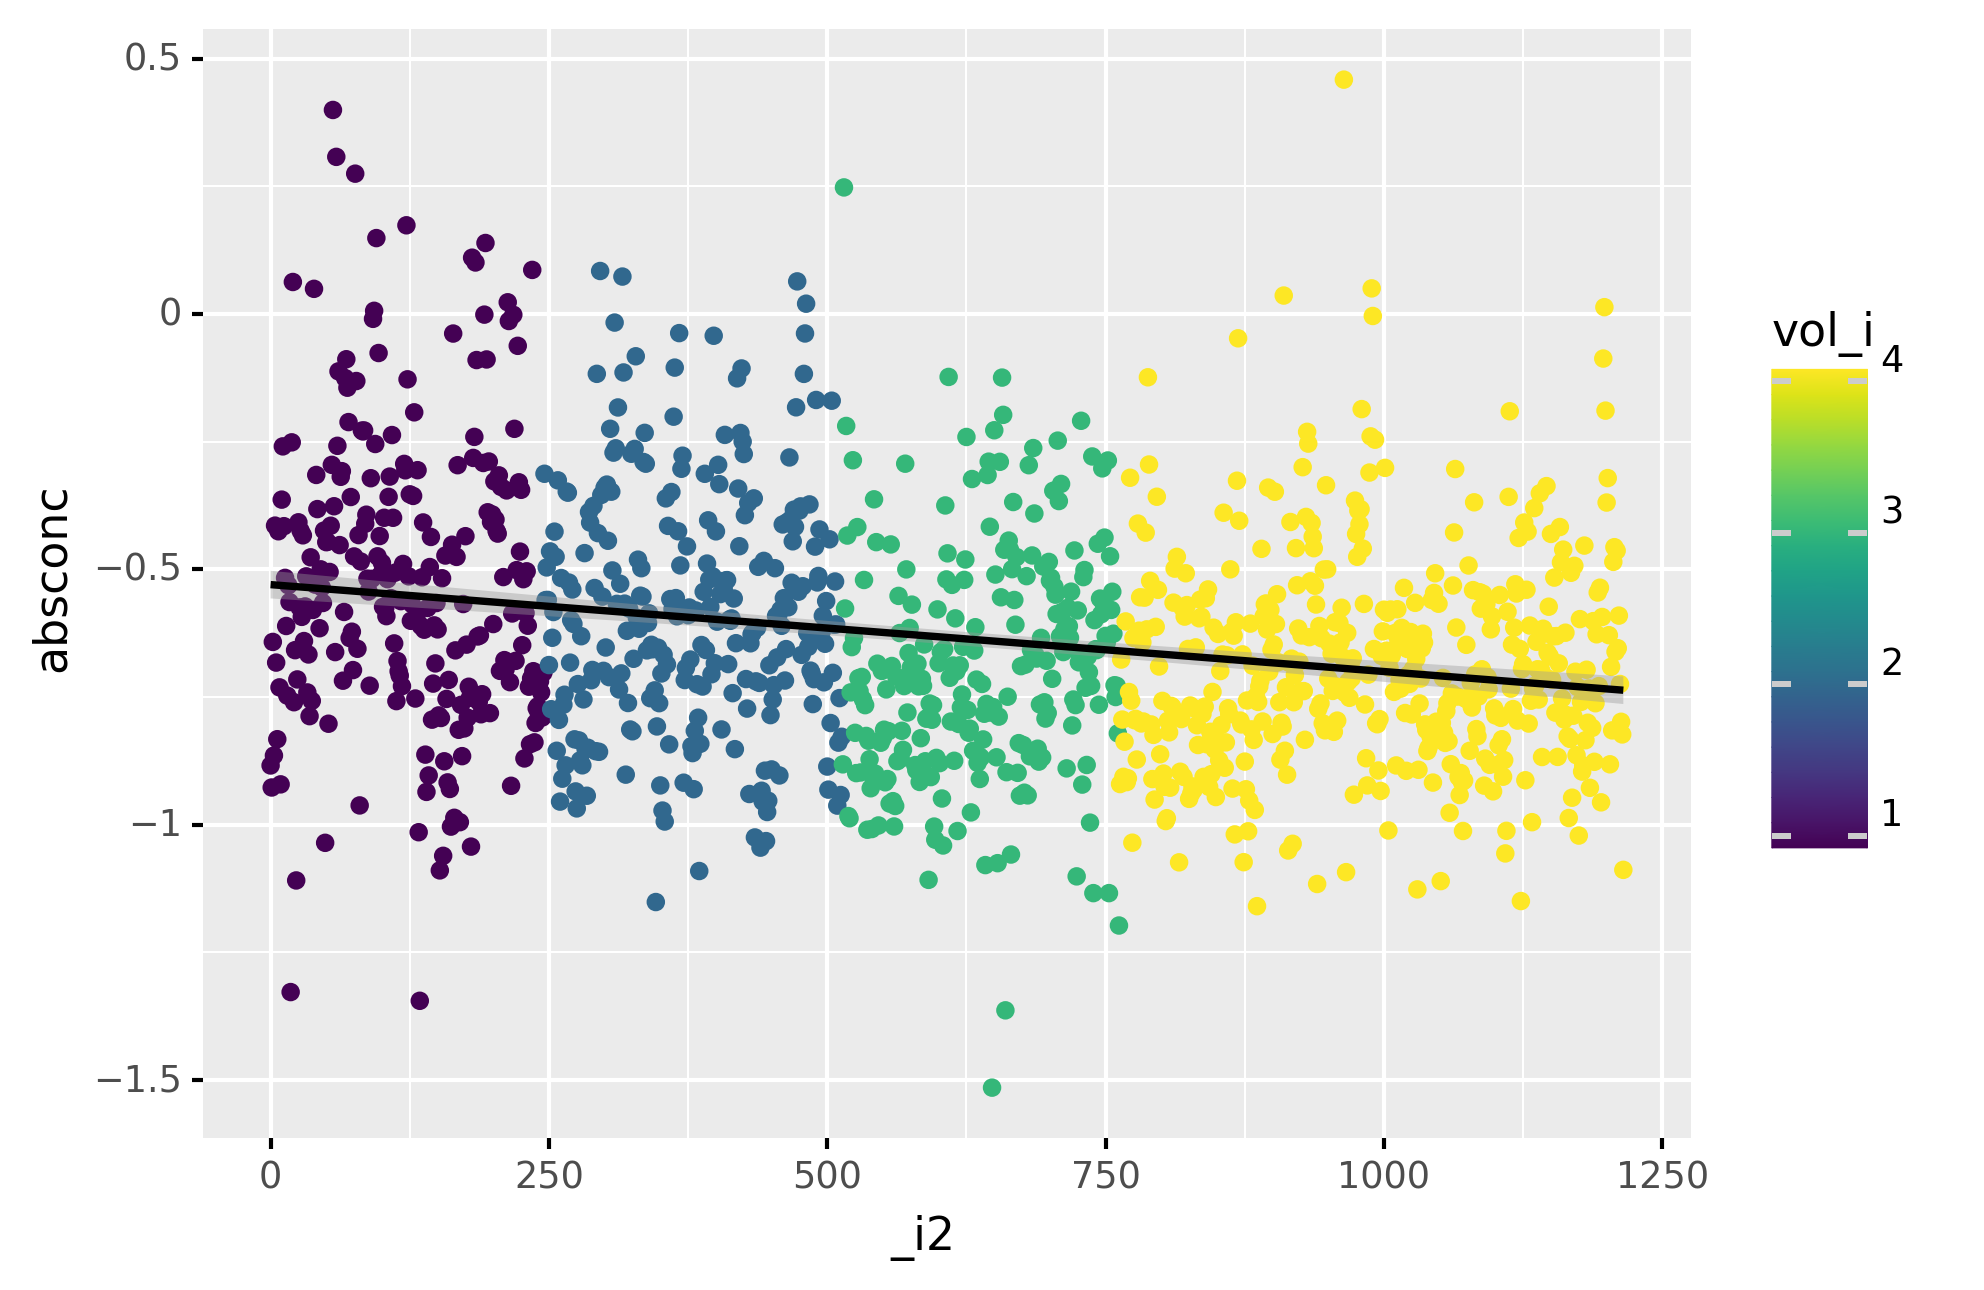

<ggplot: (733515617)>

In [46]:
fig=p9.ggplot(figdf, p9.aes(x='_i2',y='absconc',color='vol_i'))
fig+=p9.geom_point()
fig+=p9.geom_smooth()
fig

In [22]:

normsok.loc['virtue']

-1.594608020379502

In [34]:
o=pmap(get_tokens_absconc, )

para_i  sent_i  sent_token_i         token         lemma  \
text_id token_i                                                             
L001a   8             0       0             8          easy          easy   
        10            0       0            10     agreeable     agreeable   
        16            0       0            16        render        render   
        18            0       0            18       equally       equally   
        19            0       0            19    delightful    delightful   
...                 ...     ...           ...           ...           ...   
        420           9       2            51         judge         judge   
        423           9       2            54  Impartiality  impartiality   
        426           9       2            57        rarely        rarely   
        429           9       2            60           met          meet   
        433           9       2            64        Author        author   

                 onset  offset   pos pos2  deprel  head event      supersense  \
text_id token_i                                                                 
L001a   8           43      47   ADJ   JJ  advmod     2     O                   
        10          52      61   ADJ   JJ    conj     8     O                   
        16          81      87  VERB   VB    ROOT    16     O     verb.change   
        18          93     100   ADV   RB  advmod    19     O                   
        19         101     111   ADJ   JJ   ccomp    16     O                   
...                ...     ...   ...  ...     ...   ...   ...             ...   
        420       2118    2123  VERB   VB   xcomp   418     O  verb.cognition   
        423       2132    2144  NOUN   NN    pobj   421     O  noun.cognition   
        426       2154    2160   ADV   RB  advmod   425     O                   
        429       2167    2170  VERB  VBN   xcomp   425     O     verb.social   
        433       2182    2188  NOUN   NN    pobj   431     O     noun.person   

                char_id char_tok   absconc  _i  absconc_rolling_50_25  \
text_id token_i                                                         
L001a   8                        -0.886760   0                    NaN   
        10                       -1.124103   1                    NaN   
        16                       -1.331655   2                    NaN   
        18                       -1.301656   3                    NaN   
        19                       -0.263265   4                    NaN   
...                 ...      ...       ...  ..                    ...   
        420                      -1.556545  85              -0.952136   
        423                      -1.815594  86              -0.964647   
        426                      -0.243216  87              -0.979893   
        429                      -0.428958  88              -0.955655   
        433                      -1.218867  89              -0.954042   

                 absconc_rolling_50  
text_id token_i                      
L001a   8                 -0.886760  
        10                -1.005432  
        16                -1.114173  
        18                -1.161044  
        19                -0.981488  
...                             ...  
        420               -0.952136  
        423               -0.964647  
        426               -0.979893  
        429               -0.955655  
        433               -0.954042  

[90 rows x 19 columns]

In [30]:
odf.absconc.rolling(50,min_periods=25).mean()

text_id  token_i
L001a    8               NaN
         10              NaN
         16              NaN
         18              NaN
         19              NaN
                      ...   
         420       -0.952136
         423       -0.964647
         426       -0.979893
         429       -0.955655
         433       -0.954042
Name: absconc, Length: 90, dtype: float64

para_i  sent_i  sent_token_i         token         lemma  \
text_id token_i                                                             
L001a   8             0       0             8          easy          easy   
        10            0       0            10     agreeable     agreeable   
        16            0       0            16        render        render   
        18            0       0            18       equally       equally   
        19            0       0            19    delightful    delightful   
...                 ...     ...           ...           ...           ...   
        420           9       2            51         judge         judge   
        423           9       2            54  Impartiality  impartiality   
        426           9       2            57        rarely        rarely   
        429           9       2            60           met          meet   
        433           9       2            64        Author        author   

                 onset  offset   pos pos2  deprel  head event      supersense  \
text_id token_i                                                                 
L001a   8           43      47   ADJ   JJ  advmod     2     O                   
        10          52      61   ADJ   JJ    conj     8     O                   
        16          81      87  VERB   VB    ROOT    16     O     verb.change   
        18          93     100   ADV   RB  advmod    19     O                   
        19         101     111   ADJ   JJ   ccomp    16     O                   
...                ...     ...   ...  ...     ...   ...   ...             ...   
        420       2118    2123  VERB   VB   xcomp   418     O  verb.cognition   
        423       2132    2144  NOUN   NN    pobj   421     O  noun.cognition   
        426       2154    2160   ADV   RB  advmod   425     O                   
        429       2167    2170  VERB  VBN   xcomp   425     O     verb.social   
        433       2182    2188  NOUN   NN    pobj   431     O     noun.person   

                char_id char_tok   absconc  
text_id token_i                             
L001a   8                        -0.886760  
        10                       -1.124103  
        16                       -1.331655  
        18                       -1.301656  
        19                       -0.263265  
...                 ...      ...       ...  
        420                      -1.556545  
        423                      -1.815594  
        426                      -0.243216  
        429                      -0.428958  
        433                      -1.218867  

[90 rows x 16 columns]

In [7]:
df=pd.read_csv('data.abs_conc_pamela.txt',sep='\t')
df=df[df.id.str.contains('Richardson')]
df.id.value_counts()

chadwyck.Richardson.Clarissa_st_ed.1066    2309
Richardson.Pamela.Vol2                      580
Richardson.Pamela                           548
Name: id, dtype: int64

In [8]:
df['para_group']=df['para_i_all'].apply(lambda x: x//5*5)

In [9]:
df

,Unnamed: 0,abs-conc,abs/conc,abs/conc_HGI,abs/conc_MT,abs/conc_binary,count_abs,count_abs_binary,count_all,count_conc,count_conc_binary,count_neither,para,para_i,_llp_,id,para_i_all,para_group
0,0,28,15.000000,1.592593,1.441176,5.444444,30,49,100,2,9,68,"PAMELA, or VIRTUE REWARDED LETTER I DEAR FATHE...",0,canon_fiction|Richardson.Pamela,Richardson.Pamela,0,0
1,1,29,8.250000,1.051282,1.150000,2.937500,33,47,100,4,16,63,the housekeeper to give me mourning with the r...,1,canon_fiction|Richardson.Pamela,Richardson.Pamela,1,0
2,2,37,8.400000,1.666667,1.342105,6.400000,42,64,100,5,10,53,"and diligent; and do as you should do, and I l...",2,canon_fiction|Richardson.Pamela,Richardson.Pamela,2,0
3,3,45,12.250000,1.633333,1.000000,7.750000,49,62,100,4,8,47,"word! that he would be kind to you, if you wou...",3,canon_fiction|Richardson.Pamela,Richardson.Pamela,3,0
4,4,37,6.285714,1.289474,1.200000,6.777778,44,61,100,7,9,49,"it up in a rag among the thatch, over the wind...",4,canon_fiction|Richardson.Pamela,Richardson.Pamela,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,2304,69,NaN,2.000000,1.923077,26.666667,69,80,100,0,3,31,"have succeeded, in which the Favourites of the...",2304,canon_fiction|chadwyck.Richardson.Clarissa_st_...,chadwyck.Richardson.Clarissa_st_ed.1066,3432,3430
3433,2305,62,63.000000,1.769231,1.653846,16.200000,63,81,100,1,5,36,to the Genius of our Writers.’ Thus far Mr. Ad...,2305,canon_fiction|chadwyck.Richardson.Clarissa_st_...,chadwyck.Richardson.Clarissa_st_ed.1066,3433,3430
3434,2306,77,NaN,3.615385,3.222222,NaN,77,85,100,0,0,23,unhappily: Yet the Writer of the History of Cl...,2306,canon_fiction|chadwyck.Richardson.Clarissa_st_...,chadwyck.Richardson.Clarissa_st_ed.1066,3434,3430
3435,2307,65,NaN,1.720000,1.085714,79.000000,65,79,100,0,1,35,HEAVEN only could reward (d) [Footnote d: 1Kb]...,2307,canon_fiction|chadwyck.Richardson.Clarissa_st_...,chadwyck.Richardson.Clarissa_st_ed.1066,3435,3435


/Users/ryan/miniforge3/lib/python3.9/site-packages/plotnine/layer.py:402: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


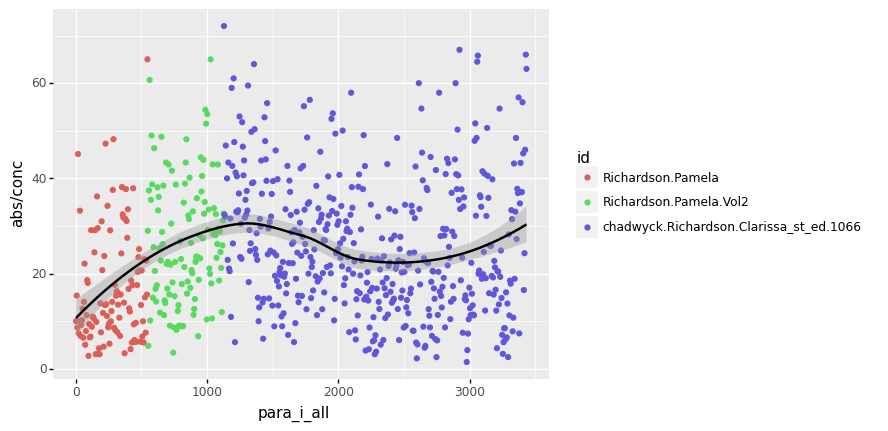

<ggplot: (693320349)>

In [11]:

(
    p9.ggplot(df.groupby(['id','para_group']).mean().reset_index(), p9.aes(x='para_i_all',y='abs/conc',color='id'))
    + p9.geom_point() 
    + p9.stat_smooth(p9.aes(x='para_i_all',y='abs/conc'),inherit_aes=False) 
    # + p9.scale_y_log10(limits=(3,30))
)